In [3]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
%autoreload 2

import sys,os,glob
import psutil

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pprint import pprint
from skimage import measure

from scipy.optimize import curve_fit

from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
from datetime import datetime as dt

import datetime as dt
import re
import gc
import matplotlib.animation as animation
import warnings

# Own settings
from settings import *

workdir = os.getcwd()
moduledir, fcndir = defineDir(workdir)

Own modules available: ['conditionalstats', 'plot2D', 'plotCondPDFs', 'plot1D', 'conditionalstats_chunked']
Own modules available: ['fcns_load_DYAMOND_SAM', 'load_TOOCAN_DYAMOND_modif', 'load_TOOCAN_DYAMOND', 'load_TOOCAN_DYAMOND_modif_BF', 'casestudy', 'settings', 'fcns_load_RCEMIP_SAM', 'PrecipGrid']


In [38]:
import conditionalstats as cs
from plot2D import *

In [39]:
region = 'tropics'
path_regrid = os.path.join(DIR_DYAMOND_PROCESSED,region,'SAM','regridded')
filename = 'prec.nc'

In [40]:
figdir = os.path.join(os.path.dirname(workdir),'figures/multiscale_extremes',region)
os.makedirs(figdir,exist_ok=True)

In [41]:
data = xr.open_dataset(os.path.join(path_regrid,filename))

In [42]:
data

<xarray.Dataset>
Dimensions:            (days: 22, lat: 1554, lat_global: 60, lon: 9216, lon_global: 360)
Coordinates:
  * lat                (lat) float32 -30.0 -29.96 -29.92 ... 29.92 29.96 30.0
  * lon                (lon) float32 0.01953 0.05859 0.09766 ... 359.9 360.0
  * lat_global         (lat_global) int64 0 1 2 3 4 5 6 ... 53 54 55 56 57 58 59
  * lon_global         (lon_global) int64 0 1 2 3 4 5 ... 355 356 357 358 359
  * days               (days) int64 0 1 2 3 4 5 6 7 ... 14 15 16 17 18 19 20 21
Data variables:
    pixel_surf         (lat, lon) float64 ...
    global_pixel_surf  (lat_global, lon_global) float64 ...
    mean_prec          (lat_global, lon_global, days) float64 ...
    max_prec           (lat_global, lon_global, days) float64 ...

In [43]:
# Compute distributions
mean_prec = data.mean_prec.values
dist_mean_prec = cs.Distribution(name="DYAMOND mean precipitation", bintype = "invlogQ", nd = 5, fill_last_decade=True)
dist_mean_prec.computeDistribution(sample = mean_prec)
dist_mean_prec.storeBinLocations(sample = mean_prec,sizemax=1000)

max_prec = data.max_prec.values
dist_max_prec = cs.Distribution(name="DYAMOND max precipitation", bintype = "invlogQ", nd = 5, fill_last_decade=True)
dist_max_prec.computeDistribution(sample = max_prec)
dist_max_prec.storeBinLocations(sample = max_prec,sizemax=1000)

In [44]:
# Compute joint distribution

jdist_prec = cs.JointDistribution(name='Prec mean vs. max',distribution1=dist_mean_prec, distribution2=dist_max_prec)
jdist_prec.computeDistribution(sample1=mean_prec,sample2=max_prec)
jdist_prec.computeNormalizedDensity(sample1=mean_prec,sample2=max_prec)
# P_Cap, Norm, Ni, Nj, Ntot= jdist_prec.computeNormalizedDensity(mean_prec, max_prec, data = None)



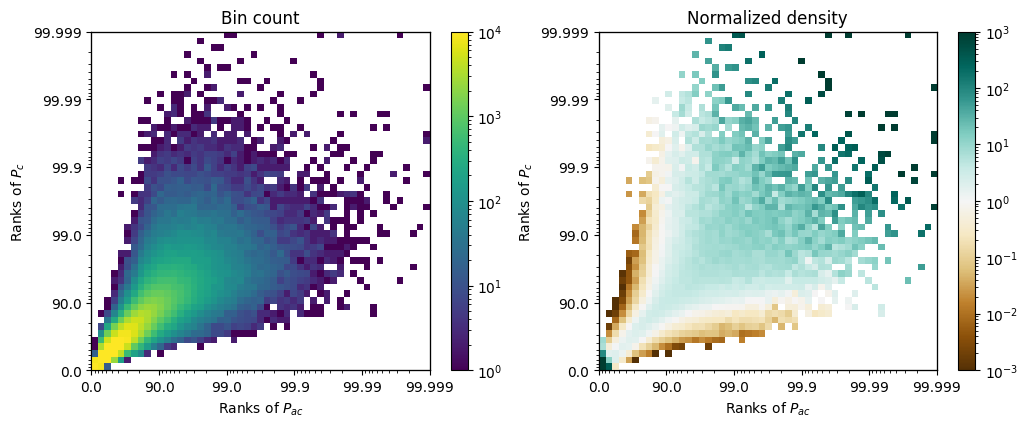

In [45]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4.4))

Z1 = jdist_prec.bincount.T
Z2 = jdist_prec.norm_density.T

titles = 'Bin count', 'Normalized density'
scales = 'log','log'
vbounds = (1,1e4),(1e-3,1e3)
cmaps = plt.cm.viridis, plt.cm.BrBG

for ax,Z,title,scale,vbds,cmap in zip(axs,(Z1,Z2),titles,scales,vbounds,cmaps):

    ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

    # Frame
    ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
    ax.set_xlabel("Ranks of $P_{ac}$")
    ax.set_ylabel("Ranks of $P_{c}$")
    ax.set_title(title)

    # Content
    pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
    
    fig.colorbar(pcm, ax=ax_show)

/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


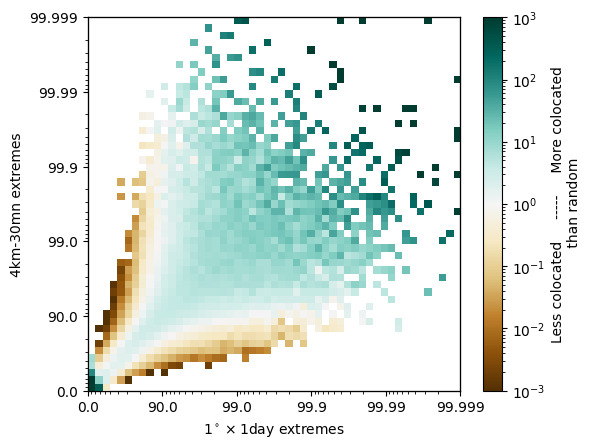

In [46]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

Z1 = jdist_prec.bincount.T
Z2 = jdist_prec.norm_density.T

title = 'Normalized density'
scale ='log'
vbnds = (1e-3,1e3)
cmap = plt.cm.BrBG

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
ax.set_xlabel(r"1$^\circ\times 1$day extremes")
ax.set_ylabel(r"4km-30mn extremes")
# ax.set_title(title)

# Content
pcm = showJointHistogram(ax_show, Z2, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)

cb = fig.colorbar(pcm, ax=ax_show)
# cb.set_label('Normalized density')
cb.set_label('Less colocated     -----     More colocated\n than random')

plt.savefig(os.path.join(figdir,'norm_density_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')

/tmp/ipykernel_4160058/174635633.py:21: UserWarning: The following kwargs were not used by contour: 'scale'
  cont = ax_show.contour(Z1,scale=scale,levels=[1e1,3e1,1e2,3e2,1e3],linewidths=0.5,colors='grey',linestyles='--')
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


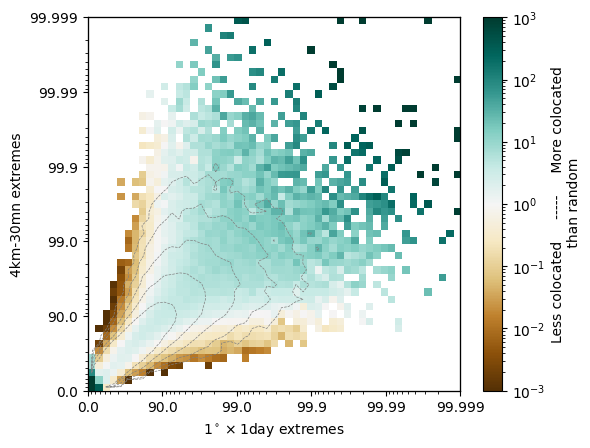

In [72]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

Z1 = jdist_prec.bincount.T
Z2 = jdist_prec.norm_density.T

title = 'Normalized density'
scale ='log'
vbds = (1e-3,1e3)
cmap = plt.cm.BrBG

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
ax.set_xlabel(r"1$^\circ\times 1$day extremes")
ax.set_ylabel(r"4km-30mn extremes")
# ax.set_title(title)

# Content
pcm = showJointHistogram(ax_show, Z2, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
cont = ax_show.contour(Z1,scale=scale,levels=[1e1,3e1,1e2,3e2,1e3],linewidths=0.5,colors='grey',linestyles='--')

cb = fig.colorbar(pcm, ax=ax_show)
# cb.set_label('Normalized density')
cb.set_label('Less colocated     -----     More colocated\n than random')

plt.savefig(os.path.join(figdir,'norm_density_contour_density_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')

/tmp/ipykernel_4160058/4170019223.py:21: UserWarning: The following kwargs were not used by contour: 'scale'
  cont = ax_show.contour(Z1,scale=scale,levels=[1e1,3e1,1e2,3e2,1e3],linewidths=0.5,colors='white',linestyles='--')
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


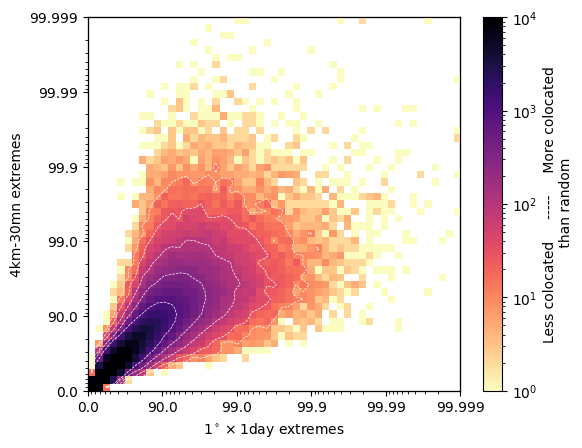

In [70]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

Z1 = jdist_prec.bincount.T
Z2 = jdist_prec.norm_density.T

title = 'Normalized density'
scale ='log'
vbds = (1,1e4)
cmap = plt.cm.magma_r

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
ax.set_xlabel(r"1$^\circ\times 1$day extremes")
ax.set_ylabel(r"4km-30mn extremes")
# ax.set_title(title)

# Content
pcm = showJointHistogram(ax_show, Z1, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
cont = ax_show.contour(Z1,scale=scale,levels=[1e1,3e1,1e2,3e2,1e3],linewidths=0.5,colors='white',linestyles='--')

cb = fig.colorbar(pcm, ax=ax_show)
# cb.set_label('Normalized density')
cb.set_label('Less colocated     -----     More colocated\n than random')

plt.savefig(os.path.join(figdir,'density_contour_density_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')

/tmp/ipykernel_4160058/3376346908.py:20: UserWarning: The following kwargs were not used by contour: 'scale'
  cont = ax_show.contour(Z,scale=scale,levels=[1])
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element

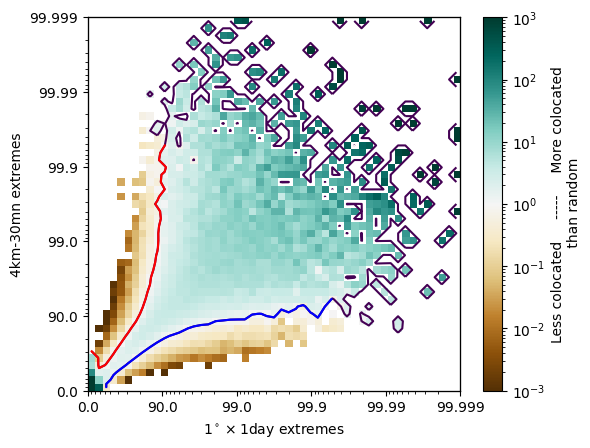

In [19]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

Z2 = jdist_prec.norm_density.T

title = 'Normalized density'
scale ='log'
vbnds = (1e-3,1e3)
cmap = plt.cm.BrBG

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
ax.set_xlabel(r"1$^\circ\times 1$day extremes")
ax.set_ylabel(r"4km-30mn extremes")
# ax.set_title(title)

# Content
pcm = showJointHistogram(ax_show, Z2, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
cont = ax_show.contour(Z2,scale=scale,levels=[1])

# Branches
N1 = 50
ax_show.plot(cont.allsegs[0][0][:N1,0],cont.allsegs[0][0][:N1,1],'b')
N2 = 50
ax_show.plot(cont.allsegs[0][0][-N2:,0],cont.allsegs[0][0][-N2:,1],'r')

cb = fig.colorbar(pcm, ax=ax_show)
# cb.set_label('Normalized density')
cb.set_label('Less colocated     -----     More colocated\n than random')

plt.savefig(os.path.join(figdir,'norm_density_max_vs_mean_prec_extremes_dev_Y_branches.pdf'),bbox_inches='tight')

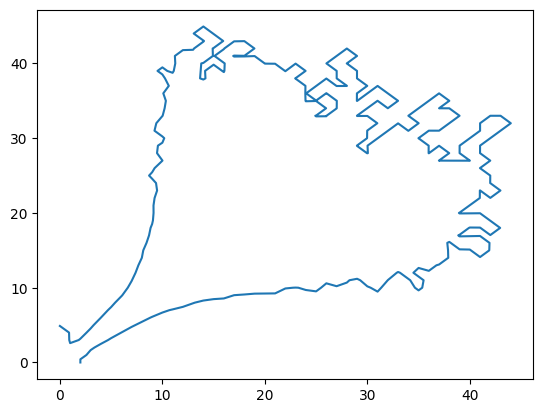

In [20]:
xdata = cont.allsegs[0][0][:,0]
ydata = cont.allsegs[0][0][:,1]

plt.plot(xdata,ydata)

In [50]:
from scipy.optimize import curve_fit

N1 = 60

xdata = cont.allsegs[0][0][:N1,0]
ydata = cont.allsegs[0][0][:N1,1]

plt.plot(xdata,ydata)

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

# fit
popt, pcov = curve_fit(func, xdata, ydata,p0=(-10,1,0))

# show
plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))


x_branch_1 = np.linspace(2,45,45)
y_branch_1 = func(x_branch_1,*popt)

# show
plt.plot(x_branch_1,y_branch_1,'k--')

plt.legend()

AttributeError: 'list' object has no attribute 'allsegs'

/tmp/ipykernel_4160058/1184430466.py:11: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * y) + c


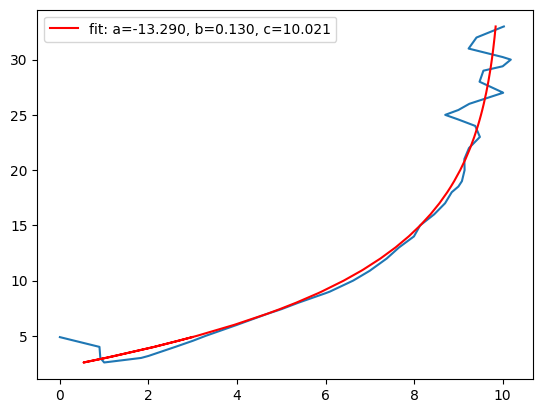

In [22]:
# Fit branch 2

N2 = 50

xdata = cont.allsegs[0][0][-N2:,0]
ydata = cont.allsegs[0][0][-N2:,1]

plt.plot(xdata,ydata)

def func(y, a, b, c):
    return a * np.exp(-b * y) + c

# fit
popt, pcov = curve_fit(func, ydata, xdata,p0=(-10,1,0))

# show
plt.plot(func(ydata, *popt),ydata, 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))


# def func(x, a, b, c):
#     return a * np.log(b * x) + c

# # fit
# popt, pcov = curve_fit(func, xdata, ydata,p0=(-1,-0.1,-10))

# # show
# plt.plot(xdata,func(xdata, *popt), 'r-',
#          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))


plt.legend()

# Automate branch detection

In [48]:
def fitBranches(cont,N):

    def func(x, a, b, c):
        return a * np.exp(-b * x) + c
    
    if cont.__class__ is list:
        seg_1 = np.flip(cont[0],axis=1)
    else:
        seg_1 = cont.allsegs[0][0]
        
    # Branch 1 -- end of contour (upward branch)
    xdata_1 = seg_1[-N:,0]
    y_1 = ydata_1 = seg_1[-N:,1]

    # fit
    popt_1, pcov_1 = curve_fit(func, ydata_1, xdata_1,p0=(-10,1,0))
    x_1 = func(ydata_1, *popt_1)
    
    # Branch 2 -- start of contour
    x_2 = xdata_2 = seg_1[:N,0]
    ydata_2 = seg_1[:N,1]

    # fit
    popt_2, pcov_2 = curve_fit(func, xdata_2, ydata_2,p0=(-10,1,0))
    y_2 = func(xdata_2, *popt_2)
    
    return popt_1, x_1, y_1, popt_2, x_2, y_2, func

/tmp/ipykernel_4160058/3094921636.py:22: UserWarning: The following kwargs were not used by contour: 'scale'
  cont = ax_show.contour(Z,scale=scale,levels=[1])
/tmp/ipykernel_4160058/3932774558.py:4: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bf

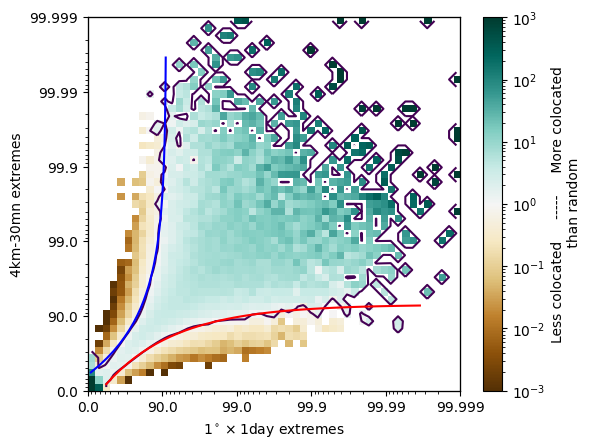

In [25]:
# Show normalized density with branches fitted

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

Z = jdist_prec.norm_density.T

title = 'Normalized density'
scale ='log'
vbnds = (1e-3,1e3)
cmap = plt.cm.BrBG

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# -- Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
ax.set_xlabel(r"1$^\circ\times 1$day extremes")
ax.set_ylabel(r"4km-30mn extremes")
# ax.set_title(title)

# -- Density
pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
cont = ax_show.contour(Z,scale=scale,levels=[1])

# -- Branches
N = 60
# fit
popt_1, x_1, y_1, popt_2, x_2, y_2, func = fitBranches(cont,N)
x_branch_2 = y_branch_1 = np.linspace(2,45,45)
y_branch_2 = func(x_branch_2,*popt_2)
x_branch_1 = func(y_branch_1,*popt_1)

# show
ax_show.plot(x_branch_1,y_branch_1,'b')
ax_show.plot(x_branch_2,y_branch_2,'r')

# ax_show.plot(x_1,y_1,'b')
# ax_show.plot(x_2,y_2,'r')


cb = fig.colorbar(pcm, ax=ax_show)
# cb.set_label('Normalized density')
cb.set_label('Less colocated     -----     More colocated\n than random')

plt.savefig(os.path.join(figdir,'norm_density_max_vs_mean_prec_extremes_dev_Y_branches.pdf'),bbox_inches='tight')

/tmp/ipykernel_2585197/3932774558.py:4: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/

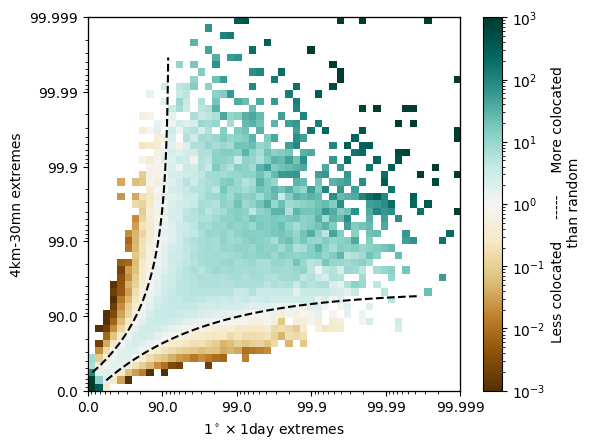

In [52]:
# Show normalized density with branches fitted -- black

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

Z = jdist_prec.norm_density.T

title = 'Normalized density'
scale ='log'
vbnds = (1e-3,1e3)
cmap = plt.cm.BrBG

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# -- Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
ax.set_xlabel(r"1$^\circ\times 1$day extremes")
ax.set_ylabel(r"4km-30mn extremes")
# ax.set_title(title)

# -- Density
pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
cont = measure.find_contours(Z, 1)

# -- Branches
N = 60
# fit
popt_1, x_1, y_1, popt_2, x_2, y_2, func = fitBranches(cont,N)
x_branch_2 = y_branch_1 = np.linspace(2,45,45)
y_branch_2 = func(x_branch_2,*popt_2)
x_branch_1 = func(y_branch_1,*popt_1)

# show
ax_show.plot(x_branch_1,y_branch_1,'k--')
ax_show.plot(x_branch_2,y_branch_2,'k--')

# ax_show.plot(x_1,y_1,'b')
# ax_show.plot(x_2,y_2,'r')


cb = fig.colorbar(pcm, ax=ax_show)
# cb.set_label('Normalized density')
cb.set_label('Less colocated     -----     More colocated\n than random')

plt.savefig(os.path.join(figdir,'norm_density_max_vs_mean_prec_extremes_Y_branches.pdf'),bbox_inches='tight')

/tmp/ipykernel_4160058/3932774558.py:4: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/

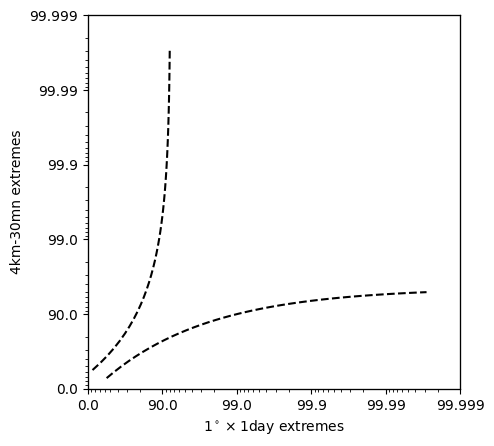

In [38]:
# Show normalized density with branches fitted -- black

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4.8,4.85))

Z = jdist_prec.norm_density.T

title = 'Normalized density'
scale = 'log'
aspect = '1'
vbnds = (1e-3,1e3)
cmap = plt.cm.BrBG

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# -- Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks,aspect=aspect)
ax.set_xlabel(r"1$^\circ\times 1$day extremes")
ax.set_ylabel(r"4km-30mn extremes")
ax.set_aspect(aspect)
# ax.set_title(title)

# -- Density
pcm = showJointHistogram(ax_show, np.full((50,50),np.nan), scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
cont = measure.find_contours(Z, 1)

# -- Branches
N = 60
# fit
popt_1, x_1, y_1, popt_2, x_2, y_2, func = fitBranches(cont,N)
x_branch_2 = y_branch_1 = np.linspace(2,45,45)
y_branch_2 = func(x_branch_2,*popt_2)
x_branch_1 = func(y_branch_1,*popt_1)

# show
ax_show.plot(x_branch_1,y_branch_1,'k--')
ax_show.plot(x_branch_2,y_branch_2,'k--')

# ax_show.plot(x_1,y_1,'b')
# ax_show.plot(x_2,y_2,'r')


# cb = fig.colorbar(pcm, ax=ax_show)
# # cb.set_label('Normalized density')
# cb.set_label('Less colocated     -----     More colocated\n than random')

plt.savefig(os.path.join(figdir,'Y_branches_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')

In [ ]:
# Show normalized density with branches fitted -- black

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4.8,4.85))

Z = jdist_prec.norm_density.T

title = 'Normalized density'
scale = 'log'
aspect = '1'
vbnds = (1e-3,1e3)
cmap = plt.cm.BrBG

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# -- Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks,aspect=aspect)
ax.set_xlabel(r"1$^\circ\times 1$day extremes")
ax.set_ylabel(r"4km-30mn extremes")
ax.set_aspect(aspect)
# ax.set_title(title)

# -- Density
pcm = showJointHistogram(ax_show, np.full((50,50),np.nan), scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
cont = measure.find_contours(Z, 1)

# -- Branches
N = 60
# fit
popt_1, x_1, y_1, popt_2, x_2, y_2, func = fitBranches(cont,N)
x_branch_2 = y_branch_1 = np.linspace(2,45,45)
y_branch_2 = func(x_branch_2,*popt_2)
x_branch_1 = func(y_branch_1,*popt_1)

# show
ax_show.plot(x_branch_1,y_branch_1,'k--')
ax_show.plot(x_branch_2,y_branch_2,'k--')

# ax_show.plot(x_1,y_1,'b')
# ax_show.plot(x_2,y_2,'r')


# cb = fig.colorbar(pcm, ax=ax_show)
# # cb.set_label('Normalized density')
# cb.set_label('Less colocated     -----     More colocated\n than random')

plt.savefig(os.path.join(figdir,'Y_branches_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')

## Save distributions and branches

In [ ]:
?

# Synthetic data

## Two independent distributions

In [22]:
import numpy.random as nr

In [23]:
# Generate two independent exponential distributions
Ns = int(1e7)
X1 = nr.exponential(size=Ns)
X2 = nr.exponential(size=Ns)

In [24]:
# Compute distributions
dist_1 = cs.Distribution(name="distribution of X1", bintype = "invlogQ", nd = 5, fill_last_decade=True)
dist_1.computeDistribution(sample = X1)
dist_1.storeBinLocations(sample = X1,sizemax=1000)

dist_2 = cs.Distribution(name="distribution of X2", bintype = "invlogQ", nd = 5, fill_last_decade=True)
dist_2.computeDistribution(sample = X2)
dist_2.storeBinLocations(sample = X2,sizemax=1000)

In [25]:
# Compute joint distribution

jdist_12 = cs.JointDistribution(name='X1 vs. X2',distribution1=dist_1, distribution2=dist_2)
jdist_12.computeDistribution(sample1=X1,sample2=X2)
jdist_12.computeNormalizedDensity(sample1=X1,sample2=X2)


/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


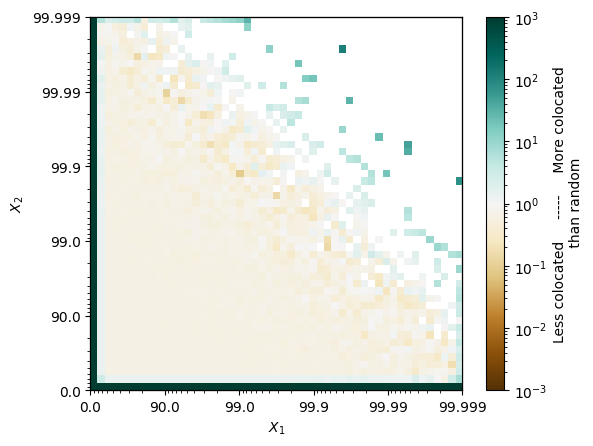

In [26]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

Z = jdist_12.norm_density.T

title = 'Normalized density'
scale ='log'
vbds = (1e-3,1e3)
cmap = plt.cm.BrBG

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# Frame
ax = setFrameIL(ax, dist_1.ranks, dist_2.ranks)
ax.set_xlabel(r"$X_1$")
ax.set_ylabel(r"$X_2$")
# ax.set_title(title)

# Content
pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
# cont = ax_show.contour(Z,scale=scale,levels=[1])

cb = fig.colorbar(pcm, ax=ax_show)
# cb.set_label('Normalized density')
cb.set_label('Less colocated     -----     More colocated\n than random')

plt.savefig(os.path.join(figdir,'norm_density_synthetic_data_independent.pdf'),bbox_inches='tight')

/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked eleme

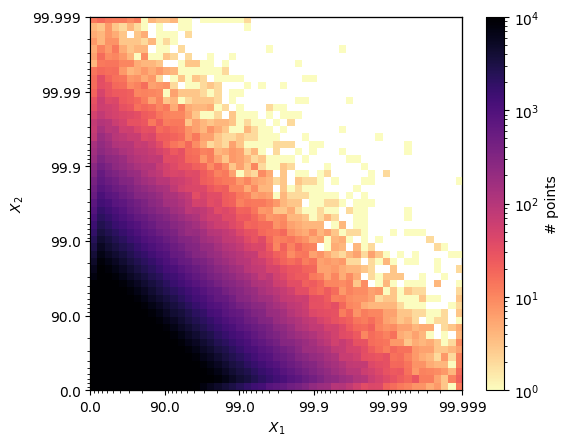

In [28]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

Z = jdist_12.bincount.T

title = 'Normalized density'
scale ='log'
vbds = (1,1e4)
cmap = plt.cm.magma_r

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# Frame
ax = setFrameIL(ax, dist_1.ranks, dist_2.ranks)
ax.set_xlabel(r"$X_1$")
ax.set_ylabel(r"$X_2$")
# ax.set_title(title)

# Content
pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
# cont = ax_show.contour(Z,scale=scale,levels=[1])

cb = fig.colorbar(pcm, ax=ax_show)
# cb.set_label('Normalized density')
cb.set_label('# points')

plt.savefig(os.path.join(figdir,'bincount_synthetic_data_independent.pdf'),bbox_inches='tight')

## Two colocated distributions

In [29]:
import numpy.random as nr

In [30]:
# Generate an exponential distribution
Ns = int(1e7)
X1 = nr.exponential(size=Ns)
# Perturb X1 by a small random noise
eps = nr.random(size=Ns)
X2 = X1+eps

In [31]:
# Compute distributions
dist_1 = cs.Distribution(name="distribution of X1", bintype = "invlogQ", nd = 5, fill_last_decade=True)
dist_1.computeDistribution(sample = X1)
dist_1.storeBinLocations(sample = X1,sizemax=1000)

dist_2 = cs.Distribution(name="distribution of X2", bintype = "invlogQ", nd = 5, fill_last_decade=True)
dist_2.computeDistribution(sample = X2)
dist_2.storeBinLocations(sample = X2,sizemax=1000)

In [32]:
# Compute joint distribution

jdist_12 = cs.JointDistribution(name='X1 vs. X2',distribution1=dist_1, distribution2=dist_2)
jdist_12.computeDistribution(sample1=X1,sample2=X2)
jdist_12.computeNormalizedDensity(sample1=X1,sample2=X2)


/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


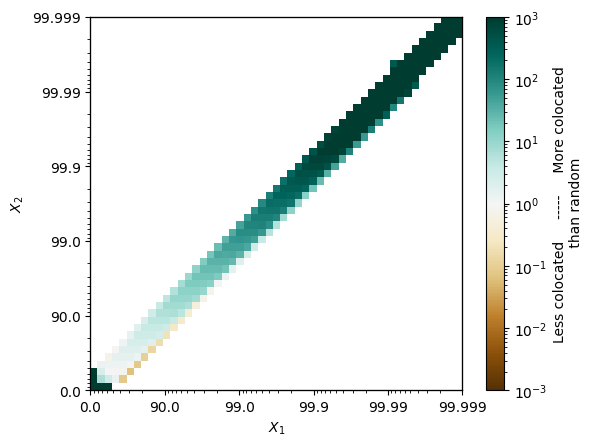

In [33]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

Z = jdist_12.norm_density.T

title = 'Normalized density'
scale ='log'
vbds = (1e-3,1e3)
cmap = plt.cm.BrBG

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# Frame
ax = setFrameIL(ax, dist_1.ranks, dist_2.ranks)
ax.set_xlabel(r"$X_1$")
ax.set_ylabel(r"$X_2$")
# ax.set_title(title)

# Content
pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
# cont = ax_show.contour(Z,scale=scale,levels=[1])

cb = fig.colorbar(pcm, ax=ax_show)
# cb.set_label('Normalized density')
cb.set_label('Less colocated     -----     More colocated\n than random')

plt.savefig(os.path.join(figdir,'norm_density_synthetic_data_correlated.pdf'),bbox_inches='tight')

/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


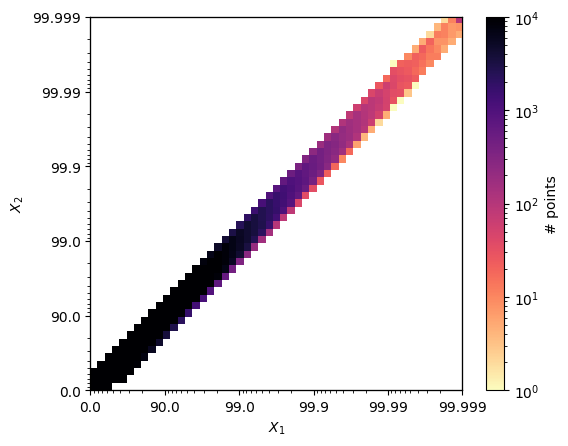

In [34]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

Z = jdist_12.bincount.T

title = 'Normalized density'
scale ='log'
vbds = (1,1e4)
cmap = plt.cm.magma_r

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# Frame
ax = setFrameIL(ax, dist_1.ranks, dist_2.ranks)
ax.set_xlabel(r"$X_1$")
ax.set_ylabel(r"$X_2$")
# ax.set_title(title)

# Content
pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
# cont = ax_show.contour(Z,scale=scale,levels=[1])

cb = fig.colorbar(pcm, ax=ax_show)
# cb.set_label('Normalized density')
cb.set_label('# points')

plt.savefig(os.path.join(figdir,'bincount_synthetic_data_correlated.pdf'),bbox_inches='tight')

# Condition data in this space

Follow up from calculation of joint density

In [ ]:
# Load conditional data



In [ ]:
# Compute conditional mean over joint density
jdist_prec.computeConditionalDataOverDensity(sample1=mean_prec,sample2=max_prec,data=)